# Contrastive Language-Image Pre-Training(CLIP) DEMO
Junjie Ren 

Dec. 24th, 2023



<img src="./image/clip_white.png" alt="Image" width="80%">



In [2]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.9927   0.004185 0.003016]]


# Motivation of Using CLIP
The motivation for integrating CLIP into the RMOT framework is to enhance its cross-modality capabilities, particularly in challenging scenarios where traditional analysis may fall short. 


- CLIP, with its robust image-text representation learning, is adept at understanding complex visual-textual queries. This becomes particularly beneficial in applications such as law enforcement pursuits, where identifying a specific vehicle is crucial. 

- For instance, license plate recognition may be hindered due to pixelation or other visual obstructions. However, CLIP can reliably discern vehicle types and potentially even make brand-specific identifications based on visual cues alone. 

- Thus, the incorporation of CLIP into RMOT aims to leverage its advanced visual recognition proficiency to compensate for scenarios where conventional image analysis methods might be insufficient.



<img src="./image/car_chase.png" alt="Image" width="50%">



# CLIP available models

In [2]:
clip.available_models()
# Returns the names of the available CLIP models.

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [3]:
clip.load('ViT-B/32', jit=False)

(CLIP(
   (visual): VisionTransformer(
     (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
     (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
     (transformer): Transformer(
       (resblocks): Sequential(
         (0): ResidualAttentionBlock(
           (attn): MultiheadAttention(
             (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
           )
           (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
           (mlp): Sequential(
             (c_fc): Linear(in_features=768, out_features=3072, bias=True)
             (gelu): QuickGELU()
             (c_proj): Linear(in_features=3072, out_features=768, bias=True)
           )
           (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
         )
         (1): ResidualAttentionBlock(
           (attn): MultiheadAttention(
             (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, 

# image to text classification

Image: 1.png
Colors: white, Confidence: 0.81%
Positions: left, Confidence: 0.75%
Items: cars, Confidence: 0.66%




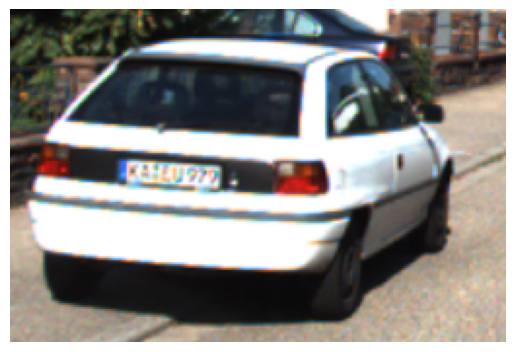

Image: 10.png
Colors: white, Confidence: 0.38%
Positions: left, Confidence: 0.78%
Items: cars, Confidence: 0.73%




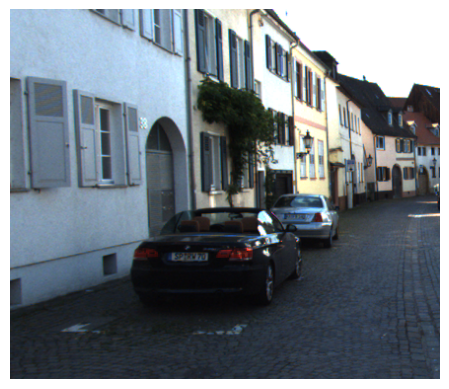

Image: 2.jpg
Colors: black, Confidence: 0.58%
Positions: left, Confidence: 0.60%
Items: vehicles, Confidence: 0.62%




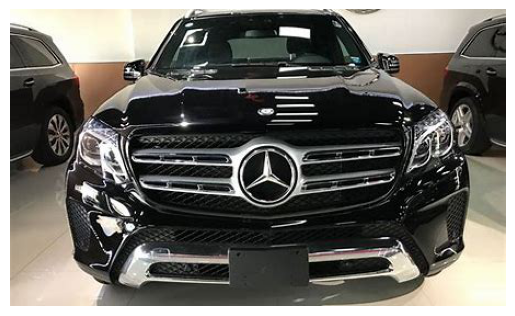

Image: 3.jpg
Colors: yellow, Confidence: 0.93%
Positions: left, Confidence: 0.52%
Items: cars, Confidence: 0.94%




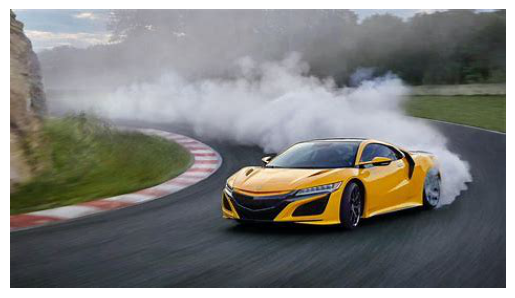

Image: 4.png
Colors: white, Confidence: 0.68%
Positions: left, Confidence: 0.78%
Items: vehicles, Confidence: 0.57%




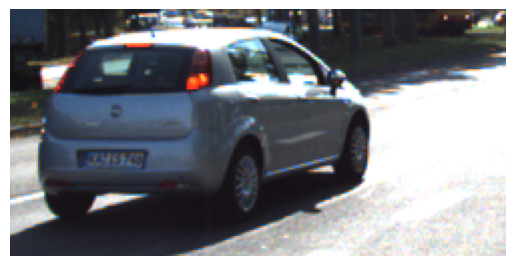

Image: 5.png
Colors: green, Confidence: 0.48%
Positions: left, Confidence: 0.73%
Items: vehicles, Confidence: 0.99%




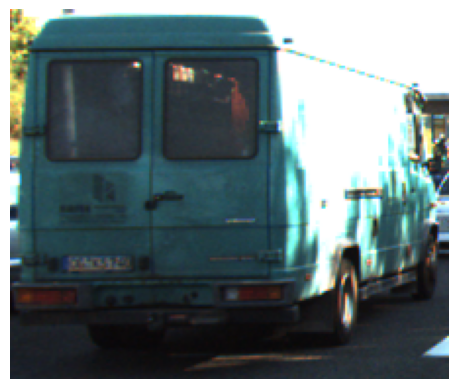

Image: 6.png
Colors: white, Confidence: 0.35%
Positions: left, Confidence: 0.56%
Items: vehicles, Confidence: 0.78%




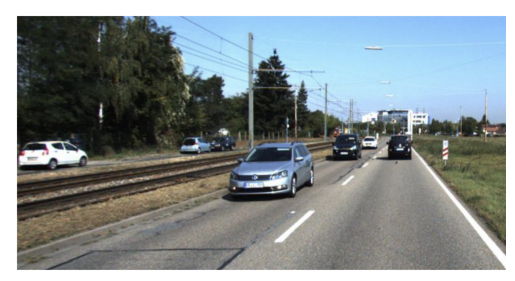

Image: 7.png
Colors: green, Confidence: 0.38%
Positions: left, Confidence: 0.60%
Items: vehicles, Confidence: 0.67%




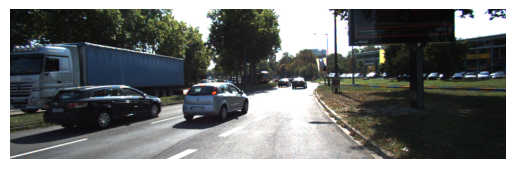

Image: 8.png
Colors: yellow, Confidence: 0.36%
Positions: right, Confidence: 0.53%
Items: vehicles, Confidence: 0.70%




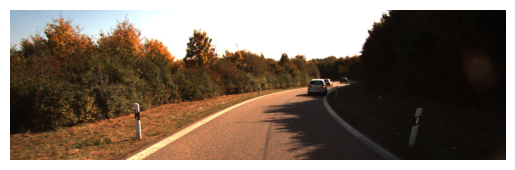

Image: 9.png
Colors: white, Confidence: 0.49%
Positions: left, Confidence: 0.75%
Items: vehicles, Confidence: 0.62%




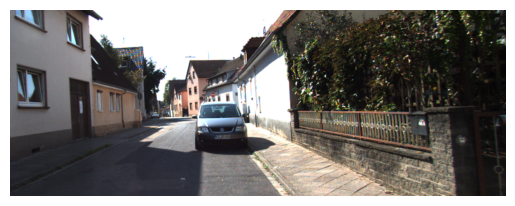

In [3]:
import os
import clip
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Folder containing images
folder_path = "color"

# Define feature categories and their corresponding candidates
feature_categories = {
    "colors": ["blue", "red", "black", "yellow","green","white"],
    "positions": ["left", "right" ],
    "items": ["cars", "vehicles"],
}

# Tokenize feature category candidates
category_tokens = {}
for category, candidates in feature_categories.items():
    category_tokens[category] = torch.cat([clip.tokenize(f"a photo of {c}") for c in candidates]).to(device)

# Iterate through images in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Assuming images have these extensions
        image_path = os.path.join(folder_path, filename)

        # Open and preprocess the image
        image = Image.open(image_path)
        image_tensor = preprocess(image).unsqueeze(0).to(device)

        # Initialize a dictionary to store predictions for each category
        predictions = {}

        # Iterate through feature categories
        for category, tokens in category_tokens.items():
            # Calculate features
            with torch.no_grad():
                image_features = model.encode_image(image_tensor)
                text_features = model.encode_text(tokens)

            # Normalize features
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            # Calculate similarity scores
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

            # Get the top prediction for each category
            max_similarity, max_index = similarity.squeeze().max(dim=0)

            # Store the prediction in the dictionary
            predictions[category] = {
                "predicted_category": feature_categories[category][max_index.item()],
                "confidence": max_similarity.item(),
            }

        # Display the image
        plt.imshow(image)
        plt.axis("off")

        # Print the result for each image
        print(f"Image: {filename}")
        for category, result in predictions.items():
            print(f"{category.capitalize()}: {result['predicted_category']}, Confidence: {result['confidence']:.2f}%")
        print("\n")

        # Show the plot
        plt.show()


# comparisons between predicted features and Ground truth

| Queries                         | Features (including confidence)         | Ground Truth         |
|---------------------------------|----------------------------------------|----------------------|
| cars in white                   | Colors: white, Confidence: 80.81%       | Colors: white        |
|                                 | Positions: left, Confidence: 75.49%     | Positions: None      |
|                                 | Items: cars, Confidence: 66.21%         | Items: cars          |
| vehicles in black               | Colors: black, Confidence: 57.81%       | Colors: white        |
|                                 | Positions: left, Confidence: 60.01%     | Positions: None      |
|                                 | Items: vehicles, Confidence: 61.87%     | Items: vehicles      |
| turning yellow cars             | Colors: yellow, Confidence: 93.07%      | Colors: yellow       |
|                                 | Positions: left, Confidence: 52.34%     | Positions: None      |
|                                 | Items: cars, Confidence: 93.99%         | Items: cars           |
| left vehicles in light white    | Colors: white, Confidence: 68.02%       | Colors: white        |
|                                 | Positions: left, Confidence: 77.98%     | Positions: left       |
|                                 | Items: vehicles, Confidence: 56.59%     | Items: vehicles      |
| moving vehicles in green        | Colors: green, Confidence: 47.63%       | Colors: green        |
|                                 | Positions: left, Confidence: 72.80%     | Positions: None      |
|                                 | Items: vehicles, Confidence: 99.12%     | Items: vehicles      |
| left vehicles in white          | Colors: white, Confidence: 34.81%       | Colors: white        |
|                                 | Positions: left, Confidence: 55.81%     | Positions: left       |
|                                 | Items: vehicles, Confidence: 77.98%     | Items: vehicles      |
| left moving vehicles in white    | Colors: white, Confidence: 38.48%       | Colors: white        |
|                                 | Positions: left, Confidence: 60.01%     | Positions: left       |
|                                 | Items: vehicles, Confidence: 67.24%     | Items: vehicles      |
| right moving vehicles in yellow | Colors: yellow, Confidence: 36.21%      | Colors: yellow       |
|                                 | Positions: right, Confidence: 53.12%    | Positions: right      |
|                                 | Items: vehicles, Confidence: 69.58%     | Items: vehicles      |
| right parking vehicles in white | Colors: white, Confidence: 49.00%       | Colors: white        |
|                                 | **Positions: left, Confidence: 75.20%**     | **Positions: right**      |
|                                 | Items: vehicles, Confidence: 61.52%     | Items: vehicles      |
| left parking cars in white       | Colors: white, Confidence: 37.79%       | Colors: white        |
|                                 | Positions: left, Confidence: 77.73%     | Positions: left       |
|                                 | Items: cars, Confidence: 72.51%         | Items: cars          |


# shortcoming of existing model 
Due to the limit of CLIP model, we can not justify whether the car is moving faster than us or not.

Because clip is a image2text,it can not process the video sequence.



<img src="./image/wrong.png" alt="Image" width="50%">


**Positions: left, Confidence: 75.20%**     | **Positions: right**  